# Library

In [ ]:
import os
import uuid
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse, FileResponse
from fastapi.middleware.cors import CORSMiddleware
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image as PILImage
from io import BytesIO

app = FastAPI()

# Configure CORS
origins = [
    "http://localhost",
    "http://localhost:8080",
    "http://localhost:8000",
    "*"  
]

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Configuration
IMG_SIZE = (299, 299)
# IMG_SIZE = (224, 224)
CLASS_NAMES = ["ARMD", "Cataract", "Diabetic", "Glaucoma", "Normal"]  
TEMP_IMAGE_DIR = "temp_images"
os.makedirs(TEMP_IMAGE_DIR, exist_ok=True)

# Load model 
try:
    model = tf.keras.models.load_model('MobileNetBaru-86.16.h5')
    # model = tf.keras.models.load_model('EfficientNetB3-93.08.h5')
    # model = tf.keras.models.load_model('InceptionV3-93.08.h5')
    
    print("Custom model loaded successfully")
    
    # base model for Grad-CAM 
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    #     include_top= False, 
    #     weights= "imagenet", 
    #     input_shape= (224, 224, 3), 
    # )
    
    # base_model = tf.keras.applications.InceptionV3(
    #     include_top= False, 
    #     weights= "imagenet", 
    #     input_shape= (299, 299, 3), 
    # )
    
    # Find last convolutional layer
    def find_last_conv_layer(model):
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                return layer.name
        raise ValueError("Could not find convolutional layer in the model")
    
    LAST_CONV_LAYER_NAME = find_last_conv_layer(base_model)
    print(f"Using layer '{LAST_CONV_LAYER_NAME}' for Grad-CAM")
    
    # Grad-CAM model
    grad_cam_model = Model(
        inputs=base_model.input,
        outputs=[base_model.get_layer(LAST_CONV_LAYER_NAME).output, base_model.output]
    )
    
except Exception as e:
    print(f"Error loading model: {e}")
    raise e
    

# Preprocessing functions 
def to_grayscale(image):
    weights = tf.constant([0.2989, 0.5870, 0.1140], dtype=tf.float32)
    grayscale_image = tf.reduce_sum(image * weights, axis=-1, keepdims=True)
    return grayscale_image

def apply_hybrid_filter(image):
    image_np = image.numpy()
    gaussian_blurred = cv2.GaussianBlur(image_np, (5, 5), 0)
    median_filtered = cv2.medianBlur(gaussian_blurred, 5)
    return tf.convert_to_tensor(median_filtered[..., np.newaxis], dtype=tf.float32)

def image_transformation(image):
    return 255.0 * (image / 255.0) ** 2

def histogram_equalization(image):
    image_np = image.numpy().astype(np.uint8)
    equalized = cv2.equalizeHist(image_np)
    return tf.convert_to_tensor(equalized[..., np.newaxis], dtype=tf.float32)

def enhanced_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    image_np = image.numpy().astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_applied = clahe.apply(image_np)
    return tf.convert_to_tensor(clahe_applied[..., np.newaxis], dtype=tf.float32)

def advanced_preprocessing(image):
    image = to_grayscale(image)
    image = apply_hybrid_filter(image)
    image = image_transformation(image)
    image = histogram_equalization(image)
    image = enhanced_clahe(image)
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    return image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_gradcam(original_img, heatmap, cam_path, alpha=0.5):
    if isinstance(original_img, tf.Tensor):
        original_img = original_img.numpy()
    
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * alpha + original_img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    cv2.imwrite(cam_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    try:
        # Generate filename
        file_ext = os.path.splitext(file.filename)[1]
        temp_filename = f"{uuid.uuid4()}{file_ext}"
        temp_filepath = os.path.join(TEMP_IMAGE_DIR, temp_filename)
        cam_filename = f"cam_{uuid.uuid4()}.jpg"
        cam_filepath = os.path.join(TEMP_IMAGE_DIR, cam_filename)
        
        # Save uploaded file temporarily
        contents = await file.read()
        with open(temp_filepath, "wb") as f:
            f.write(contents)
        
        # Load image for prediction with preprocess
        img = cv2.imread(temp_filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
        img_processed = advanced_preprocessing(img_tensor)
        
        if img_processed.shape[-1] == 1:
            img_processed = tf.repeat(img_processed, repeats=3, axis=-1)
        
        img_processed = tf.expand_dims(img_processed, axis=0)
        
        # prediction
        preds = model.predict(img_processed)[0]
        pred_index = np.argmax(preds)
        predicted_class = CLASS_NAMES[pred_index]
        confidence = float(preds[pred_index])
        
        # Generate Grad-CAM
        heatmap = make_gradcam_heatmap(
            img_processed, 
            grad_cam_model,
            LAST_CONV_LAYER_NAME,
            pred_index
        )
        
        # Load original image for visualization
        original_img = cv2.imread(temp_filepath)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.resize(original_img, IMG_SIZE)
        
        # Save Grad-CAM 
        save_gradcam(original_img, heatmap, cam_filepath, alpha=0.5) 
        
        # confidence scores
        confidence_scores = {
            CLASS_NAMES[i]: float(score) for i, score in enumerate(preds)
        }
        
        # Clean up temp files
        os.remove(temp_filepath)
        
        return JSONResponse({
            "predicted_class": predicted_class,
            "confidence": confidence,
            "confidence_scores": confidence_scores,
            "gradcam_url": f"/gradcam/{cam_filename}"
        })
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/gradcam/{filename}")
async def get_gradcam_image(filename: str):
    filepath = os.path.join(TEMP_IMAGE_DIR, filename)
    if not os.path.exists(filepath):
        raise HTTPException(status_code=404, detail="Image not found")
    return FileResponse(filepath)

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, recall_score, precision_score
from sklearn.utils import resample
from PIL import Image

from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant

import time
import shutil
import pathlib
import itertools

# import data handling tools
from sklearn.model_selection import train_test_split

# import Deep learning Libraries
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Dataset

In [2]:
data_dir = 'databarulagi'

## Labelling

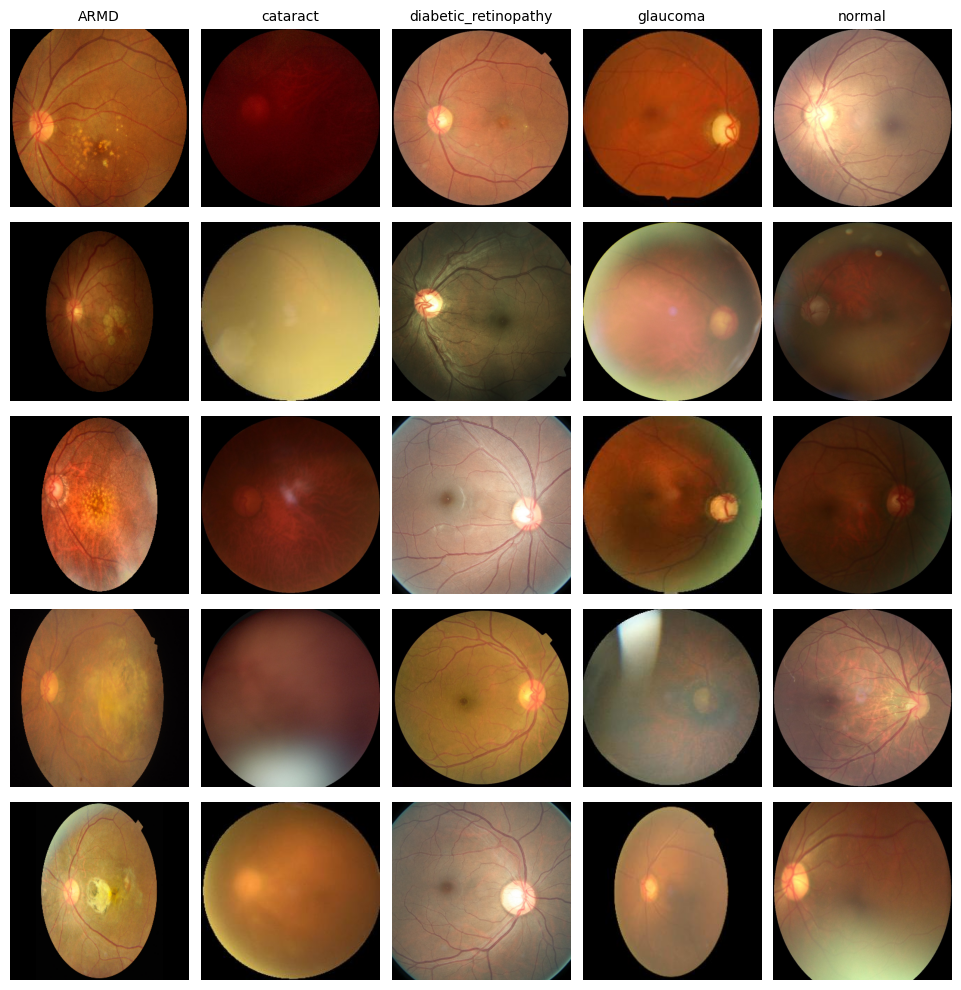

In [3]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

def get_filepaths_and_labels(data_dir):
    filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    labels = [os.path.basename(os.path.dirname(fp)) for fp in filepaths]
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

def plot_images_by_label_columns(data_dir, n_per_label=5):
    df = get_filepaths_and_labels(data_dir)
    label_groups = df.groupby('labels')

    labels = sorted(label_groups.groups.keys())
    cols = len(labels)
    rows = n_per_label

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.subplots_adjust(wspace=0, hspace=0.3)

    for col_idx, label in enumerate(labels):
        sample_images = label_groups.get_group(label).sample(n=min(n_per_label, len(label_groups.get_group(label))), random_state=42).reset_index(drop=True)
        for row_idx in range(len(sample_images)):
            ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]
            img = mpimg.imread(sample_images.iloc[row_idx]['filepaths'])
            ax.imshow(img)
            ax.axis('off')
            if row_idx == 0:
                ax.set_title(label, fontsize=10)

    plt.tight_layout()
    plt.show()

plot_images_by_label_columns('databarulagi', n_per_label=5)


## Splitting

In [4]:
def get_filepaths_and_labels(data_dir):
    filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames]
    labels = [os.path.basename(os.path.dirname(fp)) for fp in filepaths]
    return filepaths, labels

def create_dataframe(filepaths, labels):
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

def split_data(data_dir):
    filepaths, labels = get_filepaths_and_labels(data_dir)
    df = create_dataframe(filepaths, labels)
    
    train_df, temp_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=temp_df['labels'])
    
    return train_df, valid_df, test_df

# Preprocess

In [12]:
import tensorflow as tf
import cv2
import numpy as np

# Image size for model
IMG_SIZE = 299 
# IMG_SIZE = 224 

# Model preprocess input
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
# preprocess_input = tf.keras.applications.efficientnet.preprocess_input
# preprocess_input = tf.keras.applications.inception_v3.preprocess_input

# Convert RGB image to grayscale
def to_grayscale(image):
    weights = tf.constant([0.2989, 0.5870, 0.1140], dtype=tf.float32)  
    grayscale_image = tf.reduce_sum(image * weights, axis=-1, keepdims=True) 
    return grayscale_image

# Gaussian + Median filter
def apply_hybrid_filter(image):
    image_np = image.numpy()  
    
    gaussian_blurred = cv2.GaussianBlur(image_np, (5, 5), 0)
    
    median_filtered = cv2.medianBlur(gaussian_blurred, 5)
    
    return tf.convert_to_tensor(median_filtered[..., np.newaxis], dtype=tf.float32) 

# Improve Contrast
def image_transformation(image):
    return 255.0 * (image / 255.0) ** 2

# Histogram Equalization
def histogram_equalization(image):
    image_np = image.numpy().astype(np.uint8)  
    equalized = cv2.equalizeHist(image_np)
    return tf.convert_to_tensor(equalized[..., np.newaxis], dtype=tf.float32) 

# Enhanced CLAHE
def enhanced_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    image_np = image.numpy().astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_applied = clahe.apply(image_np)
    return tf.convert_to_tensor(clahe_applied[..., np.newaxis], dtype=tf.float32)


def advanced_preprocessing(image):
    image = to_grayscale(image)  # Convert to grayscale
    image = apply_hybrid_filter(image)  # Apply hybrid filter
    image = image_transformation(image)  # Apply transformation
    image = histogram_equalization(image)  # Apply histogram equalization
    image = enhanced_clahe(image)  # Apply enhanced CLAHE
    image = preprocess_input(image)

    return image

# ImageDataGenerator
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (IMG_SIZE, IMG_SIZE)
    color_mode = 'rgb'

    train_gen = ImageDataGenerator(
        preprocessing_function=advanced_preprocessing,
        # rotation_range=10,  # Random rotation
        horizontal_flip=True,  # Random horizontal flip
    ).flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=True,
        batch_size=batch_size
    )

    valid_gen = ImageDataGenerator(
        preprocessing_function=advanced_preprocessing
    ).flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=True,
        batch_size=batch_size
    )

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1)
                                  if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size

    test_gen = ImageDataGenerator(
        preprocessing_function=advanced_preprocessing
    ).flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=False,
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


In [6]:
train_df, valid_df, test_df = split_data(data_dir)

In [7]:
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 3348 validated image filenames belonging to 5 classes.
Found 419 validated image filenames belonging to 5 classes.
Found 419 validated image filenames belonging to 5 classes.


In [8]:
print(train_df['labels'].value_counts())
print(valid_df['labels'].value_counts())
print(test_df['labels'].value_counts())


normal                  835
diabetic_retinopathy    764
glaucoma                745
cataract                669
ARMD                    335
Name: labels, dtype: int64
normal                  105
diabetic_retinopathy     95
glaucoma                 93
cataract                 84
ARMD                     42
Name: labels, dtype: int64
normal                  104
diabetic_retinopathy     96
glaucoma                 93
cataract                 84
ARMD                     42
Name: labels, dtype: int64


In [9]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())    
    images, labels = next(gen)        

    length = len(labels)       
    sample = min(length, 25)  

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255     
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [10]:
train_gen.image_shape

(299, 299, 3)

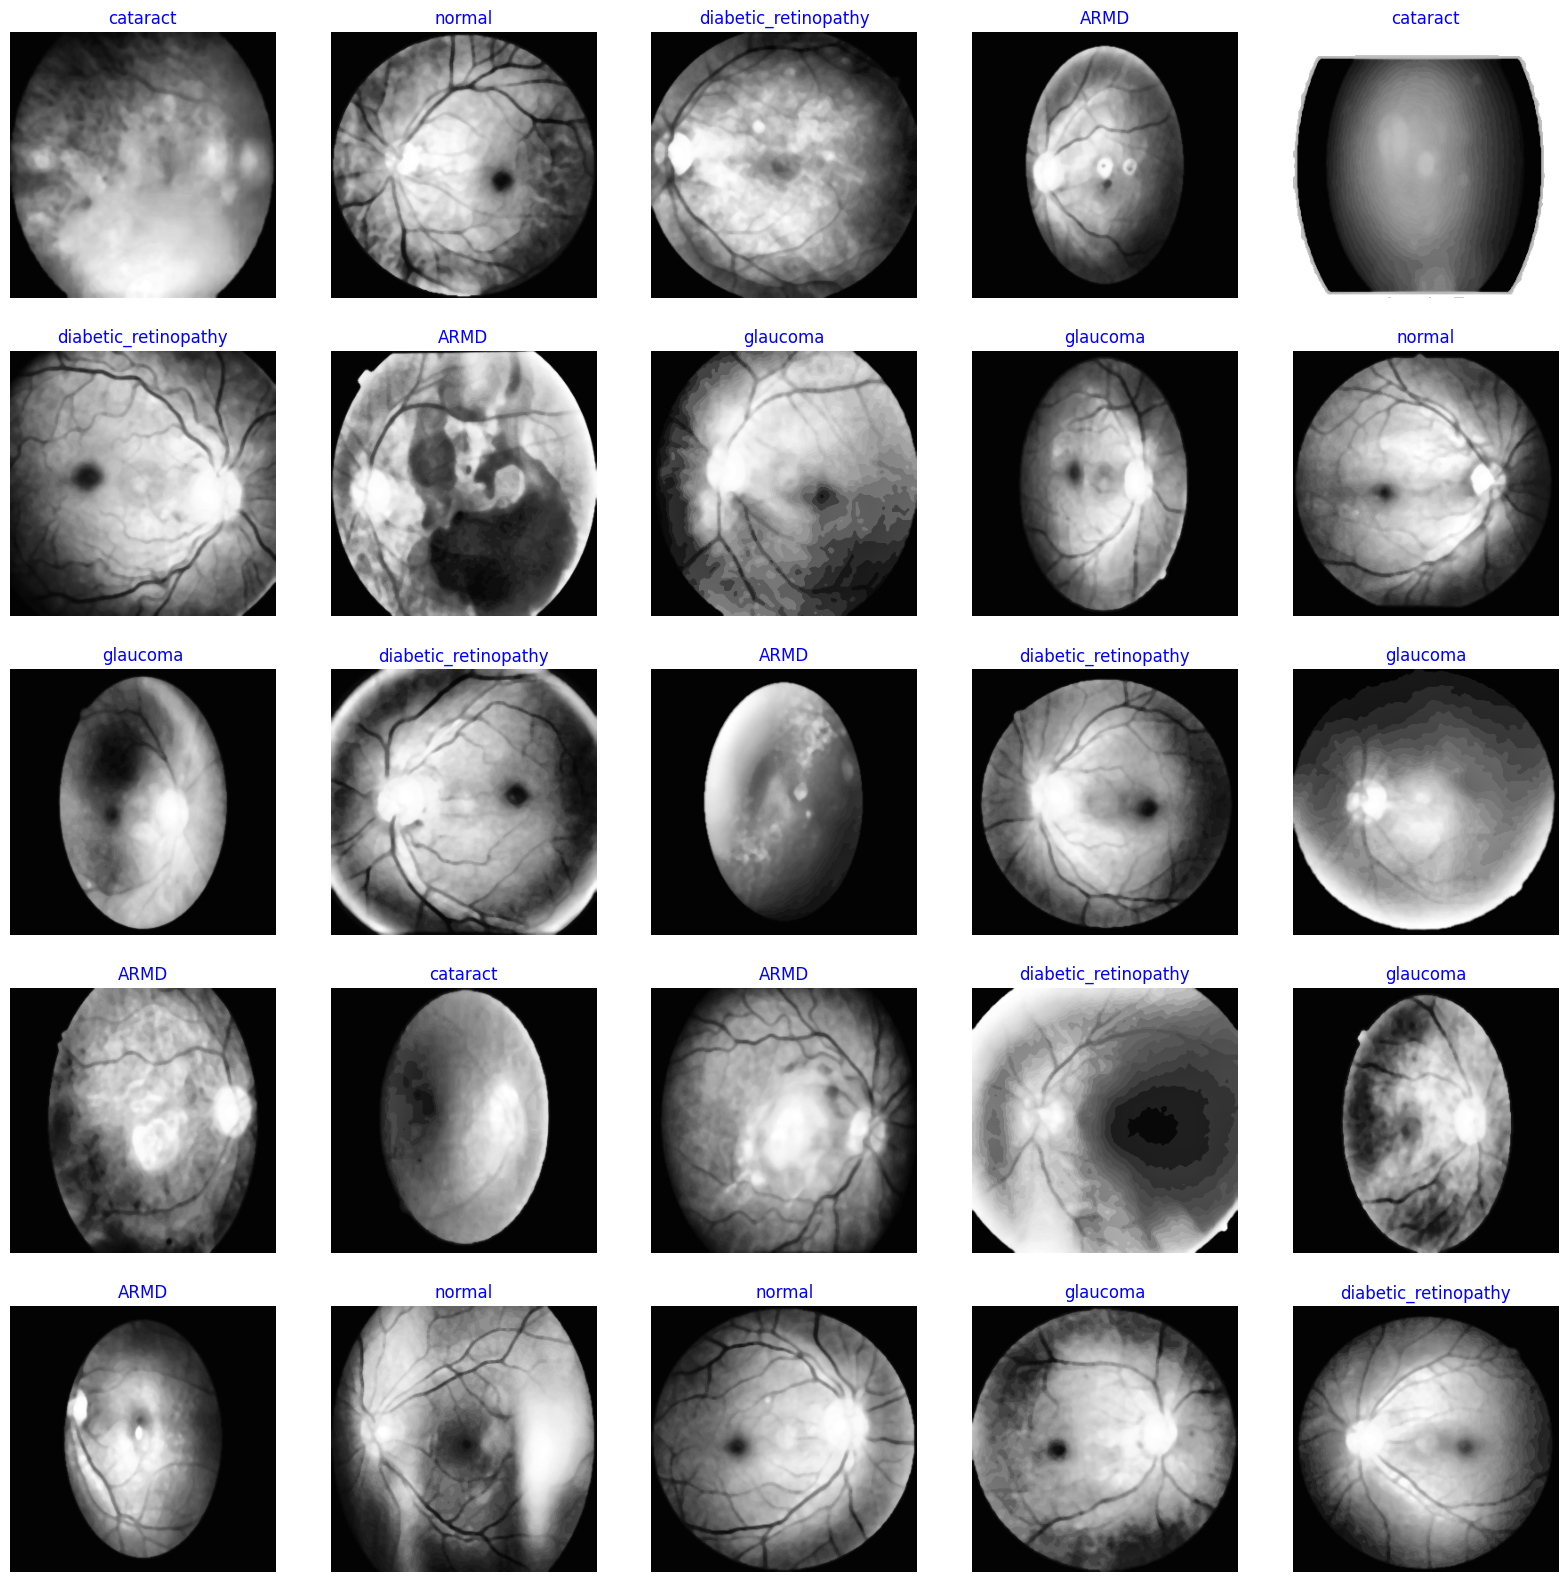

In [11]:
show_images(train_gen)

# Model

In [13]:
base_model = tf.keras.applications.MobileNetV3Small(
    include_top= False, 
    weights= "imagenet", 
    input_shape= (299, 299, 3), 
    pooling= 'max'
)

# base_model = tf.keras.applications.InceptionV3(
#     include_top= False, 
#     weights= "imagenet", 
#     input_shape= (299, 299, 3), 
#     pooling= 'max'
# )

# base_model = tf.keras.applications.efficientnet.EfficientNetB3(
#     include_top= False, 
#     weights= "imagenet", 
#     input_shape= (224, 224, 3), 
#     pooling= 'max'
# )


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.02), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),   #change the l2(l 0.016 to 0.02)
    Dropout(rate= 0.5, seed= 123),   #cheange the dropout 0.45 to 0.5 
    Dense(5, activation= 'softmax')
])
 
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 576)               2304      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               147712    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1090421 (4.16 MB)
Trainable params: 10771

## Callback

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_train_begin(self, logs=None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1

        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor   
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                else:
                    self.count = self.count + 1

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 40   # training batch size 
epochs = 30  # training epochs
patience = 1   # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]


## Class weight

In [ ]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))

class_weights = {
    0: 2.5,
    1: 1.0,
    2: 2.0,
    3: 2.0,
    4: 2.5,
}


# Train

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False, class_weight=class_weights)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /30     9.352   58.901   8.53406  35.800   0.00100  0.00100  accuracy     0.00    202.84 
 2 /30     7.419   76.792   8.07669  37.232   0.00100  0.00100  accuracy    30.38    276.77 
 3 /30     6.229   83.811   7.20259  40.811   0.00100  0.00100  accuracy     9.14    297.47 
 4 /30     5.352   86.410   6.22998  43.675   0.00100  0.00100  accuracy     3.10    266.32 
 5 /30     4.519   89.934   5.01422  48.926   0.00100  0.00100  accuracy     4.08    565.72 
 6 /30     3.848   91.667   4.28858  54.654   0.00100  0.00100  val_loss    14.47    582.24 
 7 /30     3.255   93.638   3.80331  52.029   0.00100  0.00100  val_loss    11.32    348.81 
 8 /30     2.768   94.713   3.15841  58.473   0.00100  0.00100  val_loss    16.96    205.23 
 9 /30     2.359   94.385   2.84214  59.189   0.00100  0.00100  val_loss    10.01    190.77 
10 /30     1.954   96.894   2.32834  66.348   0.00100  0.00100  val_lo

# Train History Plot

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

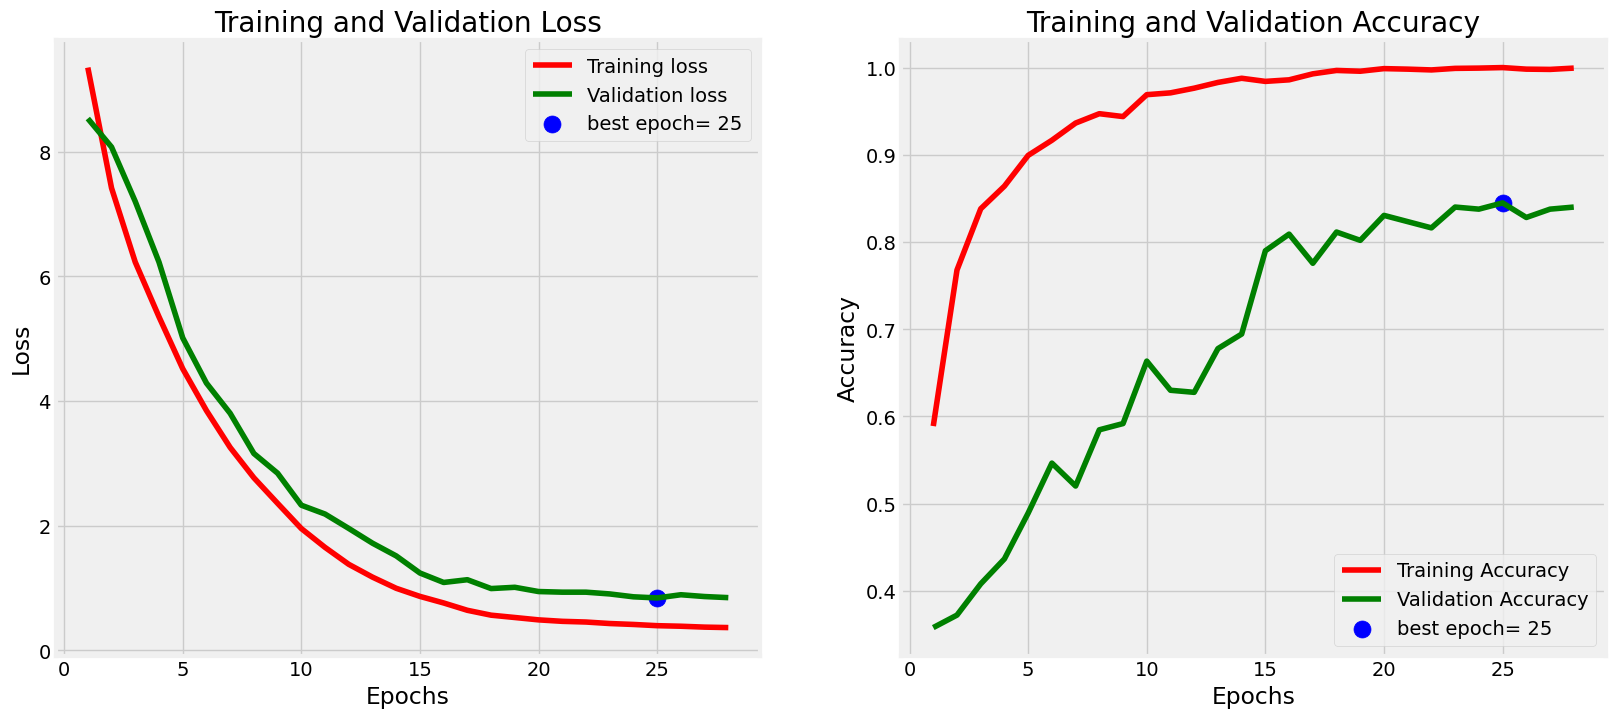

In [ ]:
plot_training(history)

# Loss and Accuracy

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

419/419 [==============================] - 18s 43ms/step - loss: 0.7682 - accuracy: 0.8616
Train Loss:  0.4698781371116638
Train Accuracy:  0.9608721733093262
--------------------
Validation Loss:  0.8401390314102173
Validation Accuracy:  0.8448687195777893
--------------------
Test Loss:  0.7682094573974609
Test Accuracy:  0.861575186252594


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

C:\Users\wahyu\AppData\Local\Temp\ipykernel_29236\2668681149.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[3 2 4 1 3 1 3 2 4 2 4 2 2 3 3 4 1 2 1 1 3 1 3 2 2 2 3 2 3 3 2 3 4 4 1 4 2
 0 3 3 2 3 3 2 3 4 4 4 2 4 1 3 4 2 4 3 1 1 3 2 4 2 0 3 3 2 3 3 1 2 2 1 4 2
 4 1 2 3 1 3 4 3 2 1 4 0 3 3 3 3 4 3 3 3 3 3 1 1 1 3 0 1 3 3 4 4 2 3 2 3 0
 3 0 2 1 2 4 4 2 0 3 4 1 2 3 4 4 3 1 2 1 2 1 4 2 2 3 4 3 4 1 1 1 0 4 2 4 3
 2 0 3 3 3 3 3 4 4 1 3 4 4 2 3 1 0 1 0 1 1 4 3 2 3 0 3 2 2 0 2 0 4 3 1 1 2
 2 4 0 2 3 1 1 3 4 4 3 0 3 2 2 1 4 2 2 2 4 4 4 4 3 3 3 1 2 4 0 3 3 3 4 3 1
 3 3 4 1 2 1 3 3 0 4 1 2 3 1 0 4 1 4 4 4 1 1 3 2 4 3 3 4 3 2 2 0 1 2 4 1 2
 3 0 1 2 3 4 2 3 1 2 1 2 2 0 4 4 2 1 1 3 4 2 2 2 2 1 3 4 2 2 2 3 2 4 3 3 3
 4 1 2 3 2 3 3 1 3 3 4 4 2 3 1 4 4 1 1 4 2 4 1 0 4 0 4 2 0 1 2 4 1 1 1 2 0
 3 2 0 2 2 3 1 4 1 1 2 1 1 2 2 4 2 2 3 0 4 1 2 2 4 3 2 1 4 3 4 1 4 3 4 3 1
 4 3 3 3 2 4 2 2 4 1 2 1 3 2 4 1 3 4 0 1 4 3 4 2 4 1 0 3 2 3 0 1 1 3 2 2 1
 1 3 2 4 2 3 0 3 1 4 2 0]


# Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[33  1  2  5  1]
 [ 0 73  0  8  3]
 [ 0  0 96  0  0]
 [ 0  6  0 80  7]
 [ 0  3  3 19 79]]
                      precision    recall  f1-score   support

                ARMD       1.00      0.79      0.88        42
            cataract       0.88      0.87      0.87        84
diabetic_retinopathy       0.95      1.00      0.97        96
            glaucoma       0.71      0.86      0.78        93
              normal       0.88      0.76      0.81       104

            accuracy                           0.86       419
           macro avg       0.88      0.85      0.86       419
        weighted avg       0.87      0.86      0.86       419



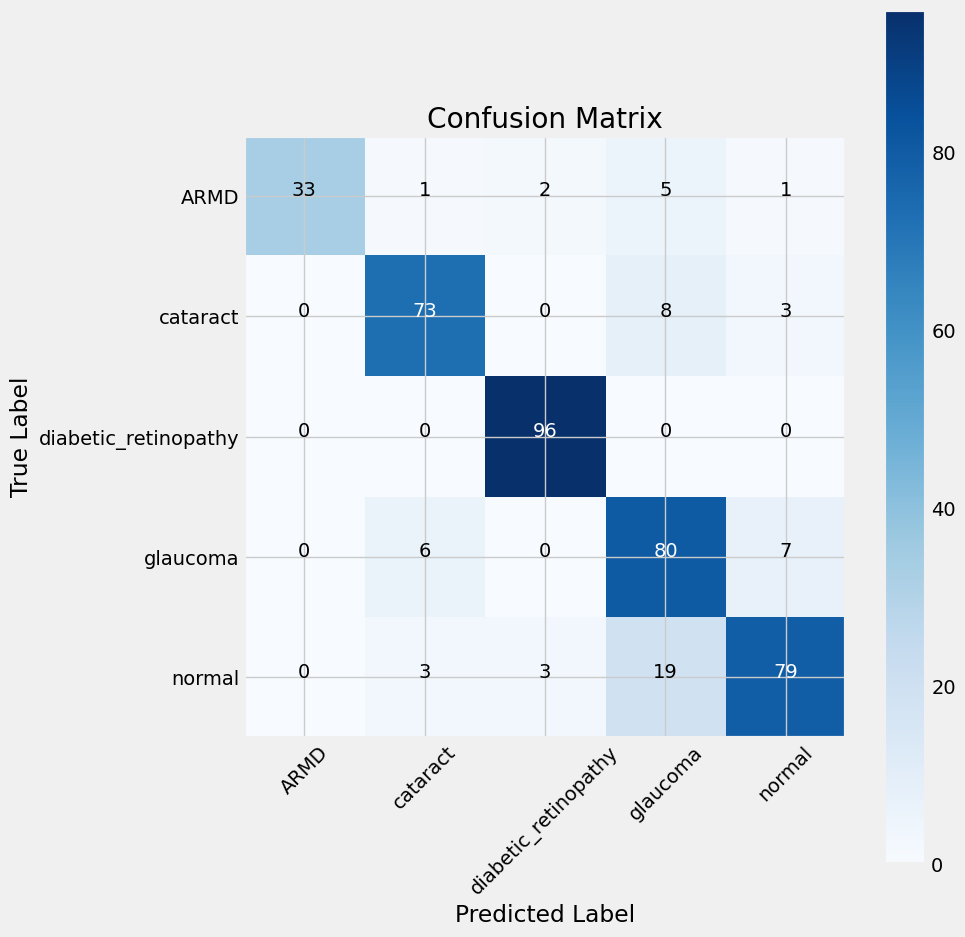

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

# Save Model

In [ ]:
subject = 'MobileNetBaru'
# subject = 'InceptionBaru'
# subject = 'EfficientBaru'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

c:\Users\wahyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as MobileNetBaru-86.16.h5


In [ ]:
stop sini

# Model Test

In [ ]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, recall_score, precision_score

from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

import time
import shutil
import pathlib
import itertools

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

# import data handling tools
from sklearn.model_selection import train_test_split

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
class_names = ["ARMD", "Cataract", "Diabetic", "Glaucoma", "Normal"]

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
# B = load_model("MobilenetBaru.keras")
B = load_model(model_save_loc)

In [ ]:
# Compile loaded model
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
B.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

IMG_SIZE = 299
# IMG_SIZE = 224  

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
# preprocess_input = tf.keras.applications.efficientnet.preprocess_input
# preprocess_input = tf.keras.applications.inception_v3.preprocess_input

def to_grayscale(image):
    """Convert RGB image to grayscale using the weighted formula."""
    weights = tf.constant([0.2989, 0.5870, 0.1140], dtype=tf.float32)  
    grayscale_image = tf.reduce_sum(image * weights, axis=-1, keepdims=True)  
    return grayscale_image

def apply_hybrid_filter(image):
    """Apply Gaussian + Median filter"""
    image_np = image.numpy()  
    
    gaussian_blurred = cv2.GaussianBlur(image_np, (5, 5), 0)
    
    median_filtered = cv2.medianBlur(gaussian_blurred, 5)
    
    return tf.convert_to_tensor(median_filtered[..., np.newaxis], dtype=tf.float32)  


def image_transformation(image):
    return 255.0 * (image / 255.0) ** 2

def histogram_equalization(image):
    image_np = image.numpy().astype(np.uint8)
    equalized = cv2.equalizeHist(image_np)
    return tf.convert_to_tensor(equalized[..., np.newaxis], dtype=tf.float32) 


def enhanced_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    image_np = image.numpy().astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_applied = clahe.apply(image_np)
    return tf.convert_to_tensor(clahe_applied[..., np.newaxis], dtype=tf.float32) 


def advanced_preprocessing(image):
    image = to_grayscale(image)  # Convert to grayscale
    image = apply_hybrid_filter(image)  # Apply hybrid filter
    image = image_transformation(image)  # Apply transformation
    image = histogram_equalization(image)  # Apply histogram equalization
    image = enhanced_clahe(image)  # Apply enhanced CLAHE
    image = preprocess_input(image)
    return image

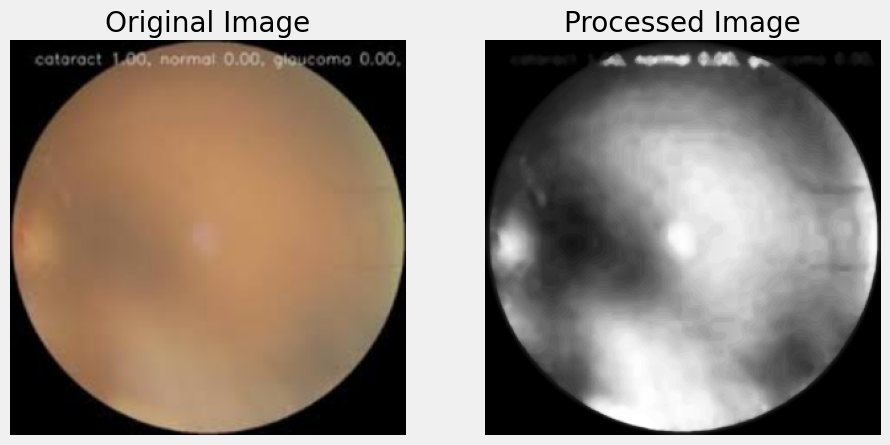

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 299  

# Load gambar
image_path = "cataract.jpg"  # path gambar 
new_image = cv2.imread(image_path)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)  
new_image = cv2.resize(new_image, (IMG_SIZE, IMG_SIZE)) 

image_tensor = tf.convert_to_tensor(new_image, dtype=tf.float32)

new_processed_image = advanced_preprocessing(image_tensor)

new_image_preprocessed_np = new_processed_image.numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(new_image / 255.0)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(new_image_preprocessed_np, cmap="gray")
plt.title("Processed Image")
plt.axis("off")

plt.show()


In [ ]:
new_image_preprocessed_np.shape

(299, 299, 1)

In [ ]:
copy_new_image = np.array(new_image_preprocessed_np).reshape(-1, 299, 299, 1) / 255.0  

In [ ]:
copy_new_image.shape

(1, 299, 299, 1)

In [ ]:
# Jika gambar hanya memiliki 1 channel, ubah menjadi 3 channel (RGB)
if copy_new_image.shape[-1] == 1:
    copy_new_image = np.concatenate([copy_new_image] * 3, axis=-1)

In [ ]:
# Prediksi menggunakan model
predictions = B.predict(copy_new_image)  
confidence = round(100 * (np.max(predictions[0])), 2)
predicted_class = np.argmax(predictions, axis=1)
predicted_label = class_names[predicted_class[0]]

print(f"Predicted Label: {predicted_label}, Confidence: {confidence}%")

1/1 [==============================] - 0s 103ms/step
Predicted Label: Cataract, Confidence: 89.5%


# XAI

## Confidence

In [ ]:
# Hasil prediksi model
predictions = B.predict(copy_new_image) 
probabilities = predictions[0]

sorted_indices = np.argsort(probabilities)[::-1]

for i in sorted_indices:
    label = class_names[i]
    confidence = round(100 * probabilities[i], 2)
    print(f"Label: {label}, Confidence: {confidence}%")



1/1 [==============================] - 0s 90ms/step
Label: Cataract, Confidence: 89.5%
Label: Diabetic, Confidence: 9.54%
Label: Normal, Confidence: 0.43%
Label: Glaucoma, Confidence: 0.28%
Label: ARMD, Confidence: 0.24%


In [ ]:
copy_new_image.shape

(1, 299, 299, 3)

## Cari conv layer

In [ ]:
# Find conv layer
for layer in base_model.layers[::-1]:  # reverse order
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name, layer.output.shape)
        break


Conv_1 (None, 10, 10, 576)


In [ ]:
model_builder = tf.keras.applications.MobileNetV3Small
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
# preprocess_input = tf.keras.applications.efficientnet.preprocess_input
# preprocess_input = tf.keras.applications.inception_v3.preprocess_input
last_conv_layer_name = "Conv_1"

## GRAD-Cam

In [ ]:
from tensorflow.keras.models import Model, Sequential

In [ ]:
def make_gradcam_heatmap(img_array, base_model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=base_model.inputs,
        outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
import PIL
import skimage 
from IPython.display import Image, display
from matplotlib.image import imread
import matplotlib.cm as cm
from tensorflow.keras.preprocessing import image

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)

    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
copy_new_image.shape

(1, 299, 299, 3)

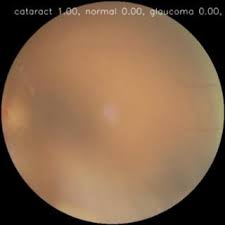

In [ ]:
# path image
img_path = "cataract.jpg"
display(Image(img_path))

In [ ]:
def load_and_preprocess_img(path, img_size=(299,299)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, img_size)
    
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    
    img_processed = advanced_preprocessing(img_tensor)  
    
    if img_processed.shape[-1] == 1:
        img_processed = tf.repeat(img_processed, repeats=3, axis=-1)
    
    img_processed = tf.expand_dims(img_processed, axis=0) 
    return img_processed


1/1 [==============================] - 0s 68ms/step


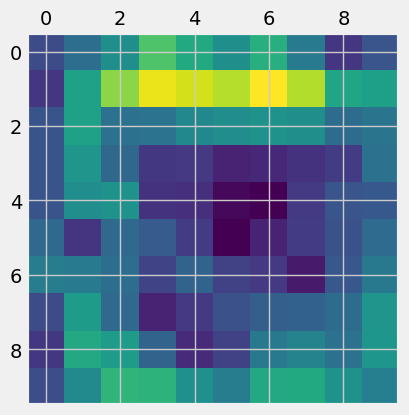

In [ ]:
img_height = 299
img_width = 299
img_size = (img_height, img_width)

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

img_array = load_and_preprocess_img(img_path, img_size=img_size)


base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(299, 299, 3),
        include_top=False,
        weights='imagenet'
    )

preds = model.predict(img_array)
pred_index = tf.argmax(preds[0])

heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name, pred_index=pred_index)

# Display heatmap
plt.matshow(heatmap)
plt.show()

C:\Users\wahyu\AppData\Local\Temp\ipykernel_29236\488390952.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


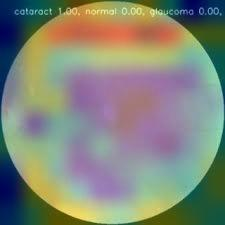

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

## Prediksi

In [ ]:
import numpy as np

In [ ]:
import numpy as np


preds = model.predict(img_array)[0]  

for i, confidence in enumerate(preds):
    print(f"{class_names[i]}: {confidence:.4f}")

pred_index = np.argmax(preds)
print(f"\nPredicted class: {class_names[pred_index]} with confidence {preds[pred_index]:.4f}")


1/1 [==============================] - 0s 86ms/step
ARMD: 0.0034
Cataract: 0.9788
Diabetic: 0.0076
Glaucoma: 0.0048
Normal: 0.0055

Predicted class: Cataract with confidence 0.9788
